# Objetivo do notebook:

Definição e importância
Implicações em amostragem
Aplicações práticas e exemplos
Testes Estatísticos

Introdução a testes estatísticos
T-test, F-test, Z-test: conceitos, aplicações e diferenças
Chi-squared e Kolmogorov Smirnov: conceitos, aplicações e diferenças

In [1]:
import pandas as pd 
import seaborn as sns
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import chi2_contingency

In [2]:
data = sns.load_dataset('car_crashes')


In [3]:
data.describe()

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,15.790196,4.998196,4.886784,13.573176,14.004882,886.957647,134.493137
std,4.122002,2.017747,1.729133,4.508977,3.764672,178.296285,24.835922
min,5.900000,1.792000,1.593000,1.760000,5.900000,641.960000,82.750000
25%,12.750000,3.766500,3.894000,10.478000,11.348000,768.430000,114.645000
50%,15.600000,4.608000,4.554000,13.857000,13.775000,858.970000,136.050000
75%,18.500000,6.439000,5.604000,16.140000,16.755000,1007.945000,151.870000
max,23.900000,9.450000,10.038000,23.661000,21.280000,1301.520000,194.780000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total           51 non-null     float64
 1   speeding        51 non-null     float64
 2   alcohol         51 non-null     float64
 3   not_distracted  51 non-null     float64
 4   no_previous     51 non-null     float64
 5   ins_premium     51 non-null     float64
 6   ins_losses      51 non-null     float64
 7   abbrev          51 non-null     object 
dtypes: float64(7), object(1)
memory usage: 3.3+ KB


In [5]:
data.head()

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses,abbrev
0,18.8,7.332,5.640,18.048,15.040,784.55,145.08,AL
1,18.1,7.421,4.525,16.290,17.014,1053.48,133.93,AK
2,18.6,6.510,5.208,15.624,17.856,899.47,110.35,AZ
3,22.4,4.032,5.824,21.056,21.280,827.34,142.39,AR
4,12.0,4.200,3.360,10.920,10.680,878.41,165.63,CA


## Corrigindo outliers

In [6]:

def correct_outliers(df, columns):
    """
    Correct outliers in specific columns of a DataFrame.
    
    Parameters:
    df (DataFrame): The input DataFrame
    columns (list): The list of column names to correct for outliers
    
    Returns:
    DataFrame: A new DataFrame with outliers corrected
    """
    
    corrected_df = df.copy()
    
    for col in columns:
        # Compute the IQR (Inter Quartile Range) for this column
        Q1 = corrected_df[col].quantile(0.25)
        Q3 = corrected_df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define bounds for the outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Replace outliers with lower and upper bounds
        corrected_df[col] = corrected_df[col].apply(lambda x: lower_bound if x < lower_bound else x)
        corrected_df[col] = corrected_df[col].apply(lambda x: upper_bound if x > upper_bound else x)
        
    return corrected_df
# Apply the function
data = correct_outliers(data, ['total', 'speeding', 'alcohol', 'not_distracted', 'no_previous', 'ins_premium', 'ins_losses'])

## Feature engineering

In [7]:
# Lista de estados considerados como parte do Sul dos EUA
southern_states = ['AL', 'AR', 'DE', 'FL', 'GA', 'KY', 'LA', 'MD', 'MS', 'MO',
                   'NC', 'OK', 'SC', 'TN', 'TX', 'VA', 'WV']

# Criar uma nova coluna 'region' que é 'North' se o estado não estiver na lista southern_states, e 'South' caso contrário
data['region'] = data['abbrev'].apply(lambda x: 'South' if x in southern_states else 'North')


## Variáveis do conjunto de dados:

- total: Número total de acidentes (por bilhão de milhas)
- speeding: A proporção de acidentes que envolvem excesso de velocidade
- alcohol: A proporção de acidentes que envolvem álcool
- not_distracted: A proporção de acidentes que não envolvem distração
- no_previous: A proporção de acidentes de motoristas sem acidentes anteriores
- ins_premium: Prêmio médio de seguro de automóvel por ano (em dólares)
- ins_losses: Perdas de seguro por veículo/ano (em dólares)
- abbrev: Abreviação do estado dos EUA

## T-test
Conceito:
O T-test é um teste estatístico que compara as médias de duas amostras e determina se são estatisticamente diferentes entre si. Ele é baseado na distribuição T de Student.

Aplicações:

Comparar as médias de duas amostras independentes (ex: médias de salários entre homens e mulheres).
Comparar a média de uma amostra com um valor conhecido ou esperado (ex: verificar se a média de uma turma é igual à média esperada).
Comparar as médias de uma amostra antes e depois de um tratamento (ex: efeitos de um medicamento).

Vamos utilizar aqui para comparar se a quantidade de batidas de carro por região são significativamente diferentes.

### Suposições do ttest:

- Normalidade:
As amostras devem ser aproximadamente normalmente distribuídas. Essa suposição é especialmente importante quando o tamanho da amostra é pequeno. Para tamanhos de amostra grandes, o Teorema do Limite Central frequentemente assegura que a média da amostra seja aproximadamente normal, mesmo se os dados brutos não forem.
- Independência:
As observações dentro de cada amostra devem ser independentes umas das outras. Isso significa que uma observação em um grupo não deve afetar as observações no outro grupo.
- Variância Homogênea (Homocedasticidade):
Essa suposição, que é também chamada de homocedasticidade, implica que as variâncias dentro de cada um dos grupos que estão sendo comparados devem ser iguais. Quando essa suposição é violada, estamos em um cenário de heterocedasticidade. Existem variações do teste t (como o teste t de Welch) que são mais robustas quando essa suposição é violada.
- Amostras Aleatórias:
As amostras devem ser selecionadas aleatoriamente da população. Isso é fundamental para garantir que as amostras sejam representativas da população da qual foram retiradas.
- Nível de Medição:
O teste t é usado para comparar as médias, portanto, a variável dependente deve ser contínua (nível de intervalo ou de razão).


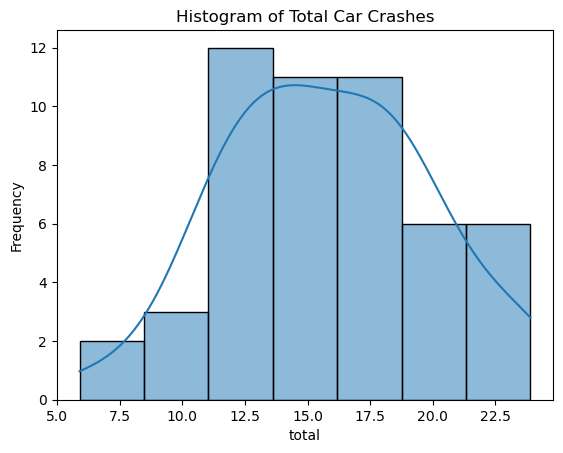

In [8]:
sns.histplot(data['total'], kde=True)
plt.title('Histogram of Total Car Crashes')
plt.xlabel('total')
plt.ylabel('Frequency')
plt.show()

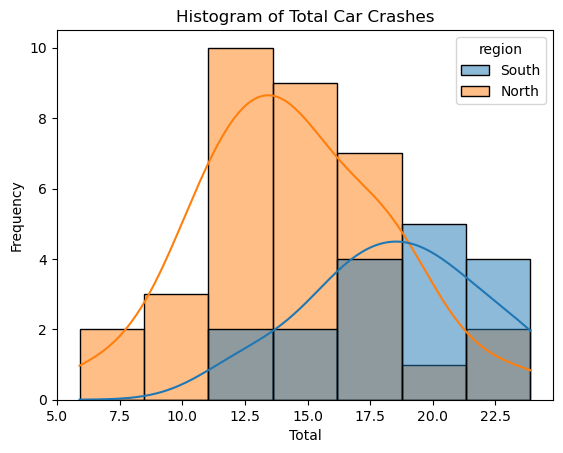

In [9]:
sns.histplot(data=data, x='total', hue='region', kde=True)
plt.title('Histogram of Total Car Crashes')
plt.xlabel('Total')
plt.ylabel('Frequency')
plt.show()

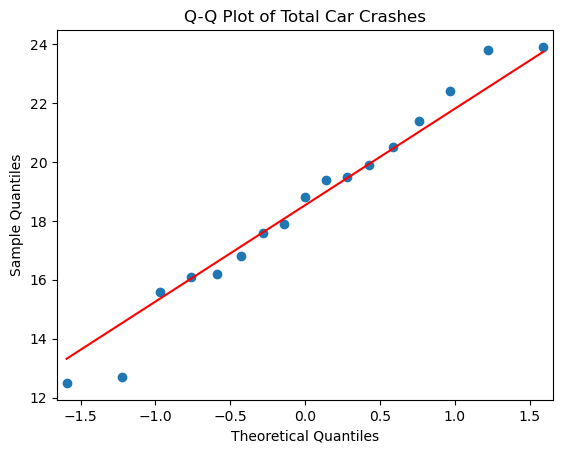

In [10]:
sm.qqplot(data[data['region']=='South']['total'], line='s')
plt.title('Q-Q Plot of Total Car Crashes')
plt.show()

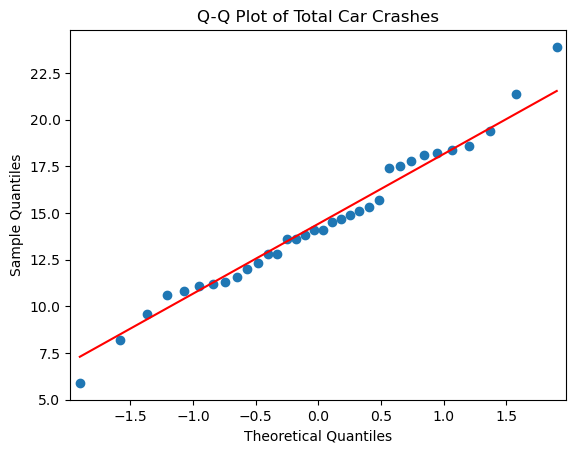

In [11]:
sm.qqplot(data[data['region']=='North']['total'], line='s')
plt.title('Q-Q Plot of Total Car Crashes')
plt.show()

In [12]:
data['region'].value_counts()

North    34
South    17
Name: region, dtype: int64

In [13]:
# Teste de Levene para identificar h
stat, p = stats.levene(data[data['region']=='North']['total'], data[data['region']=='South']['total'])

# Resultado
print("Levene Statistic:", stat)
print("P-Value:", p)

if p < 0.05:
    print("Provavelmente as variâncias são diferentes")
else:
    print("Provavelmente as variâncias são iguais")

Levene Statistic: 0.15260440196007935
P-Value: 0.6977521007186569
Provavelmente as variâncias são iguais


## Realizando t_test

- Idependentes
- Distribuições com Homocedasticidade

In [14]:
t_stat, p_value= stats.ttest_ind(data[data['region']== 'North']['total'], data[data['region']=='South']['total'])

In [15]:
# Imprimindo os resultados
print("T-statistic:", t_stat)
print("P-value:", p_value)

# Avaliando o resultado com um nível de significância de 0.05
if p_value < 0.05:
    print("Provavelmente há uma diferença significativa entre as médias de acidentes dos estados do norte e dos estados no sul.")
else:
    print("Provavelmente não há uma diferença significativa entre as médias dos grupos.")

T-statistic: -3.77408633799677
P-value: 0.0004340995967240015
Provavelmente há uma diferença significativa entre as médias de acidentes dos estados do norte e dos estados no sul.


### ADENDO: Por terem populações diferentes de pessoas, tamanho de tráfego diferente, etc. Não há como provar que proporcionalmente, o sul tem mais acidentes que o norte.

## Z-test
O teste Z é um teste estatístico que ajuda a determinar se duas médias de amostras são diferentes quando as variâncias são conhecidas e o tamanho da amostra é grande. Ele é usado para testar hipóteses, onde a hipótese nula geralmente afirma que não há diferença entre as médias das duas populações.

Teste Z é usado quando a amostra é grande (geralmente, n > 30 é considerado grande), e a população tem uma distribuição normal com variância conhecida.
Teste t é usado quando a amostra é pequena (geralmente, n < 30) e a variância da população é desconhecida. O teste t também é mais robusto quando a distribuição da população não é normal.

Vamos utilizar o Z-test agora para realizar a mesma comparação anterior.

In [16]:
Z_stat, p_value= stats.ttest_ind(data[data['region']== 'North']['total'], data[data['region']=='South']['total'])
# Imprimindo os resultados
print("Z-statistic:", Z_stat)
print("P-value:", p_value)

# Avaliando o resultado com um nível de significância de 0.05
if p_value < 0.05:
    print("Provavelmente há uma diferença significativa entre as médias de acidentes dos estados do norte e dos estados no sul.")
else:
    print("Provavelmente não há uma diferença significativa entre as médias dos grupos.")

Z-statistic: -3.77408633799677
P-value: 0.0004340995967240015
Provavelmente há uma diferença significativa entre as médias de acidentes dos estados do norte e dos estados no sul.


### Como o tamanho é médio. Pode-se esperar que ambos os testes vão ter performances parecidas.

## F-test
### O F-test (ou teste F) é uma classe de testes estatísticos que tem como base a distribuição F, que é a razão de duas variâncias. Ele é usado para comparar a variabilidade de dois ou mais grupos. 

#### Vamos usar o f-test para comparar se as porcentagens de acidentes de carro por velocidade nos estados varia da mesma maneira que a porcentagem de acidentes de carro causados por alcool.

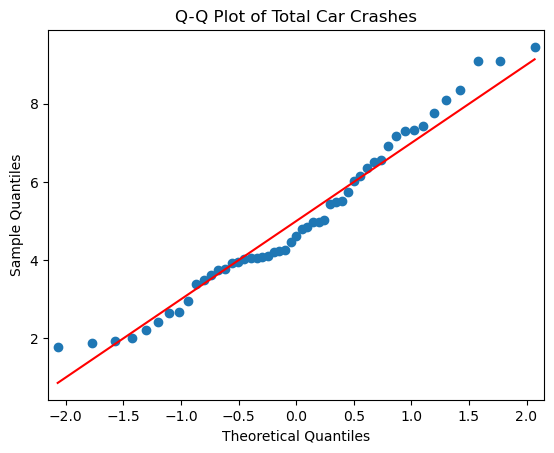

In [17]:
sm.qqplot(data['speeding'], line='s')
plt.title('Q-Q Plot of Total Car Crashes')
plt.show()

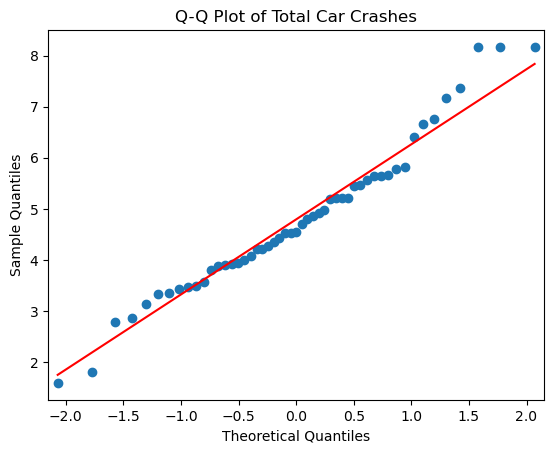

In [18]:
sm.qqplot(data['alcohol'], line='s')
plt.title('Q-Q Plot of Total Car Crashes')
plt.show()

In [19]:
# Calculando a estatística F
f_stat = data['speeding'].var() / data['alcohol'].var()
p_value = stats.f.cdf(f_stat, len(data['speeding']) - 1, len(data['alcohol']) - 1)

In [20]:
# Imprimindo os resultados
print("F-statistic:", f_stat)
print("P-value:", p_value)

# Avaliando o resultado com um nível de significância de 0.05
if p_value < 0.05:
    print("Provavelmente as variâncias são diferentes.")
else:
    print("Provavelmente as variâncias são iguais.")

F-statistic: 1.847342570853323
P-value: 0.9839271919316878
Provavelmente as variâncias são iguais.


### A proporção de acidentes causadas por velocidade, varia de forma semelhante as proporções de acidentes causadas por álcool.

## Chi-squared Test (χ²)
- Conceito:
O Teste Qui-quadrado é utilizado para determinar se existe uma associação significativa entre duas variáveis categóricas.

- Aplicações:

Testar a independência entre duas variáveis categóricas (ex: gênero e preferência de produto).

Testar a adequação do ajuste de uma distribuição observada a uma distribuição esperada (teste de adequação do ajuste).

Vamos considerar um exemplo em que queremos verificar se há uma associação significativa entre duas variáveis categóricas no conjunto de dados car_crashes. Para ilustrar isso, vamos criar duas novas variáveis categóricas a partir dos dados contínuos:

Alcohol_involved: Acidentes com envolvimento de álcool (‘Yes’ ou ‘No’), usando a mediana de alcohol como ponto de corte.

High_Speeding: Acidentes com alta velocidade envolvida (‘Yes’ ou ‘No’), usando a mediana de speeding como ponto de corte.

In [21]:
# Criando as novas variáveis categóricas
data['Alcohol_involved'] = ['Yes' if x > data['alcohol'].median() else 'No' for x in data['alcohol']]
data['High_Speeding'] = ['Yes' if x > data['speeding'].median() else 'No' for x in data['speeding']]

In [22]:
# Criando uma tabela de contingência
contingency_table = pd.crosstab(data['Alcohol_involved'], data['High_Speeding'])

# Realizando o teste Qui-Quadrado
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Exibindo os resultados
print("Chi-Squared Value:", chi2)
print("P-Value:", p_value)

# Interpretando o p-valor
alpha = 0.05
if p_value < alpha:
    print("Há uma associação significativa entre alta da proporção de álcool e alta da proporção de velocidade nos acidentes.")
else:
    print("Não há uma associação significativa entre envolvimento de álcool e alta velocidade nos acidentes.")

Chi-Squared Value: 5.657952071005916
P-Value: 0.017376401015167114
Há uma associação significativa entre alta da proporção de álcool e alta da proporção de velocidade nos acidentes.


## Kolmogorov-Smirnov Test
- Conceito:
O Teste de Kolmogorov-Smirnov é usado para comparar a distribuição de uma amostra com uma distribuição teórica (como a normal), ou para comparar as distribuições de duas amostras.

- Aplicações:

Testar se uma amostra segue uma determinada distribuição teórica (normal, exponencial, etc.).

Comparar as distribuições de duas amostras para verificar se são significativamente diferentes.

In [23]:
# Teste K-S de uma amostra para verificar se a coluna 'alcohol' segue uma distribuição normal
ks_statistic, p_value = stats.kstest(data['alcohol'], 'norm', args=(data['alcohol'].mean(), data['alcohol'].std()))

# Exibindo os resultados
print("K-S Statistic:", ks_statistic)
print("P-Value:", p_value)

# Interpretando o p-valor
alpha = 0.05
if p_value < alpha:
    print("Podemos rejeitar a hipótese nula de que a distribuição de 'alcohol' segue uma distribuição normal.")
else:
    print("Não podemos rejeitar a hipótese nula de que a distribuição de 'alcohol' segue uma distribuição normal.")

K-S Statistic: 0.08697812184320453
P-Value: 0.8032992159162543
Não podemos rejeitar a hipótese nula de que a distribuição de 'alcohol' segue uma distribuição normal.
